# Laboratorio 8

## Univariate regression on analytical functions

1. Use the following snippet of code to create you initial dataset.

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from prettytable import PrettyTable

In [2]:
def f1(x): return x*np.sin(x) + 2*x
def f2(x): return 10*np.sin(x) + np.power(x,2)
def f3(x): return np.sign(x)*(np.power(x,2)+300) + 20*np.sin(x)

In [3]:
tr = 20
n_samples = 100
X = np.linspace(-tr, tr, n_samples)

2. Draw and inspect the shape of the function

<AxesSubplot:>

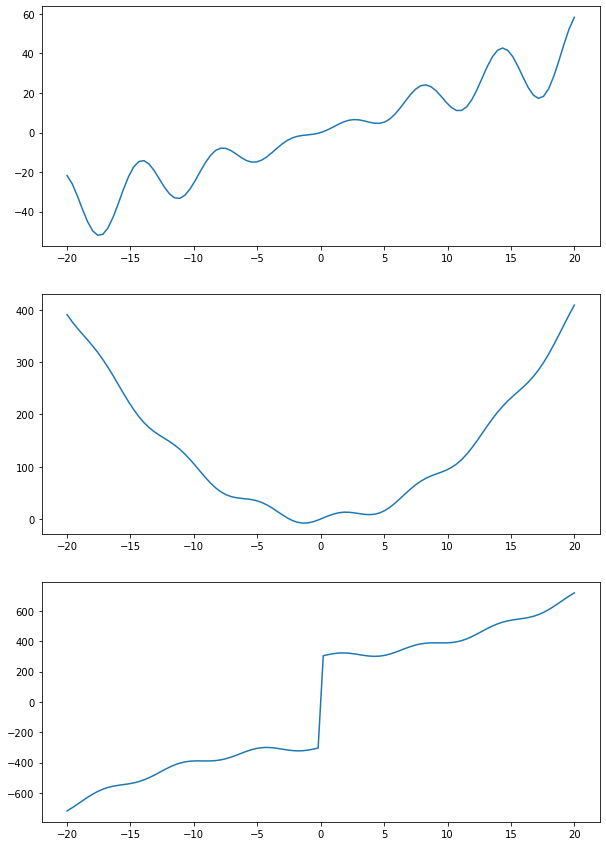

In [4]:
fig, axs = plt.subplots(3,1,figsize=(10,15))
sns.lineplot(x=X,y=f1(X),ax=axs[0])
sns.lineplot(x=X,y=f2(X),ax=axs[1])
sns.lineplot(x=X,y=f3(X),ax=axs[2])

3. Frame now a regression task to your generated data. Start from the ordinary least squares Linear Regression.

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

def generate_train_test(x, f = None, y = None, train_size=0.3, random_state = None):
    if y is None: y = f(x)
    X_train, X_test, y_train, y_test = train_test_split(
        x,
        y,
        train_size=train_size,
        random_state=random_state,
        shuffle=True
    )
    y_test = y_test[X_test.argsort()]
    X_test.sort()
    return X_train, X_test, y_train, y_test

def evaluate_model(x, model, f = None, y = None, train_size = 0.3, random_state = None):
    X_train, X_test, y_train, y_test = generate_train_test(x, f = f, y = y, train_size=train_size, random_state=random_state)

    X_train = X_train.reshape(-1,1)
    X_test = X_test.reshape(-1,1)
    y_train = y_train.ravel()
    y_test = y_test.ravel() 

    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)

    # data_train = pd.DataFrame(np.concatenate((X_train,y_train),axis=1), columns=['X_train','y_train'])
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(x,f(x),label='ground truth',color='lightseagreen')
    ax.scatter(X_train,y_train,label='train points',color='navy')
    ax.plot(X_test,y_pred,color='tomato')

    return mean_squared_error(y_test,y_pred), r2_score(y_test,y_pred)

(96.05432293962889, 0.810699729140167)

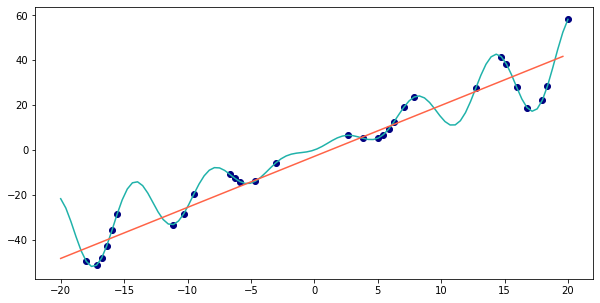

In [6]:
# evaluate_model(X, f1, LinearRegression(n_jobs=-2))
evaluate_model(X, Ridge(), f1)
# evaluate_model(X, f1, SVR())
# evaluate_model(X, f1, RandomForestRegressor(n_estimators=1000))
# evaluate_model(X, f1, make_pipeline())
# evaluate_model(X, f1, MLPRegressor(hidden_layer_sizes=(100,100), random_state=42))

D:\Anaconda\envs\data_science_lab_2\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


+-----------------------------+--------------------+---------------------+
|            model            |        MSE         |          R2         |
+-----------------------------+--------------------+---------------------+
|       LinearRegression      | 77.47218993806494  |  0.8773472280698357 |
|            Ridge            | 77.50073828878843  |  0.8773020307628656 |
|             SVR             | 327.2211651250417  | 0.48194851637871683 |
|    RandomForestRegressor    | 58.80618590182422  |  0.9068989567318865 |
|         MLPRegressor        | 82.32779391445182  |  0.8696599110135462 |
| PolynomialRegression_simple | 131.0269322886152  |  0.7925601889458346 |
|   PolynomialRegression_sin  | 131.05306596224497 |  0.7925188145182629 |
+-----------------------------+--------------------+---------------------+


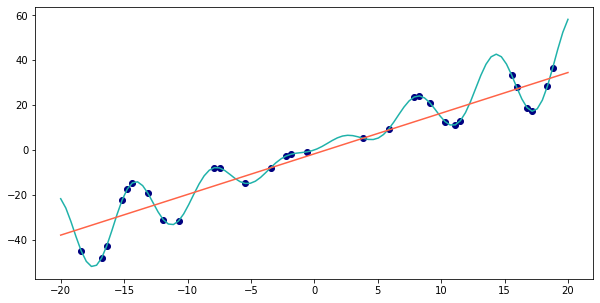

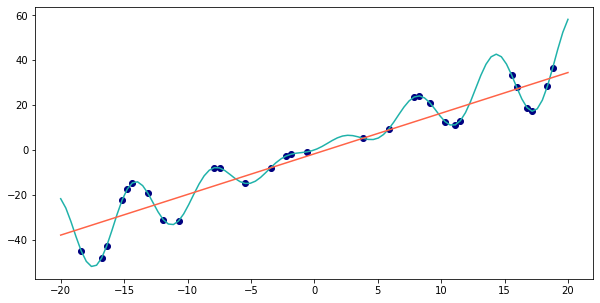

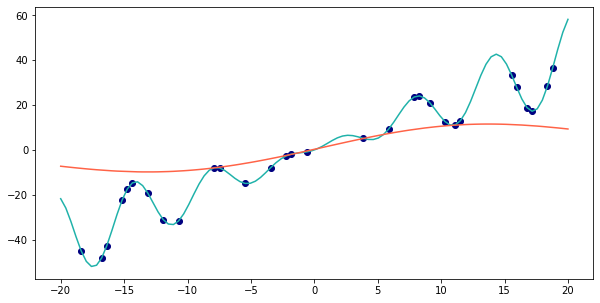

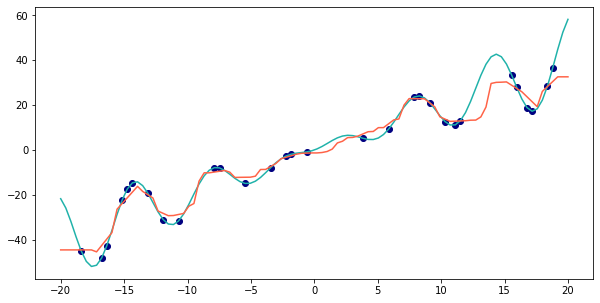

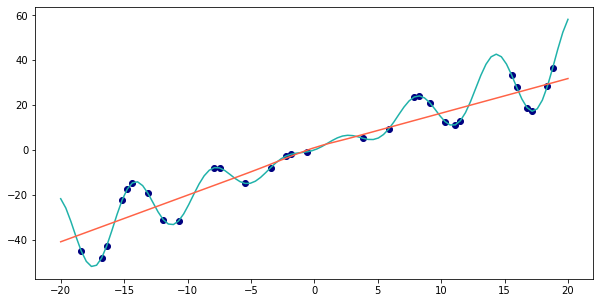

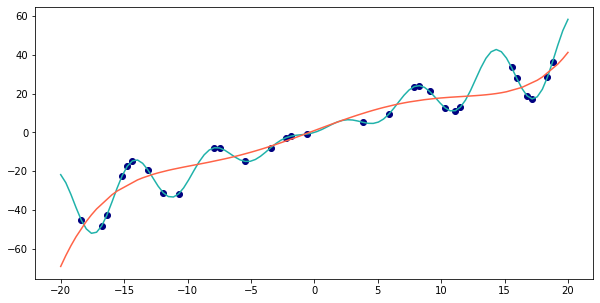

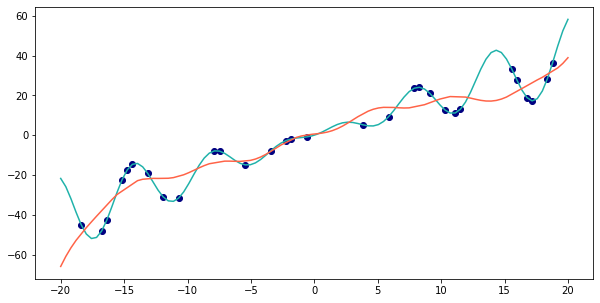

In [8]:
t = PrettyTable()
t.field_names = ['model', 'MSE', 'R2']

models = [
    LinearRegression(), 
    Ridge(),
    SVR(),
    RandomForestRegressor(n_estimators=1000),
    MLPRegressor(hidden_layer_sizes=(100,100), random_state=42),
    make_pipeline(
        make_column_transformer(
            (PolynomialFeatures(degree=5),[0])
        ),
        LinearRegression()
    ),
    make_pipeline(
        make_column_transformer(
            (FunctionTransformer(np.sin),[0]),
            (PolynomialFeatures(degree=5),[0])
        ),
        LinearRegression()
    )
]
model_names = ['LinearRegression', 'Ridge', 'SVR', 'RandomForestRegressor', 'MLPRegressor', 'PolynomialRegression_simple', 'PolynomialRegression_sin']

for model, name in zip(models, model_names):
    mse, r2 = evaluate_model(X, model, f1, random_state=39)
    t.add_row([name, mse, r2])

print(t)

Test di LinearRegression

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

LR_model = LinearRegression(n_jobs=-2)

X_train, X_test, y_train, y_test = train_test_split(X.reshape(-1,1),f1(X.reshape(-1,1)),train_size=0.3,random_state=42,shuffle=True)

LR_model.fit(X_train,y_train)

print(mean_squared_error(y_true=y_test,y_pred=LR_model.predict(X_test)))
print(r2_score(y_true=y_test,y_pred=LR_model.predict(X_test)))

65.72227592689515
0.8950661957810067


Test di MLPRegressor e GridSearchCV

In [10]:
from sklearn.model_selection import ParameterGrid, GridSearchCV


parameters ={
    'hidden_layer_sizes' : [(200,200),(100,100)],
    'solver' : ['lbfgs','sgd','adam']
}

X_train, X_test, y_train, y_test = generate_train_test(X, f1)
X_train = X_train.reshape(-1,1)
X_test = X_test.reshape(-1,1)
y_train = y_train.ravel()
y_test = y_test.ravel()

gscv1 = GridSearchCV(
    estimator=MLPRegressor(max_iter=1000), 
    param_grid=parameters, 
    scoring='neg_mean_squared_error',
    n_jobs=-2
)

gscv1.fit(X_train,y_train)

y_pred = gscv1.predict(X_test)

print(mean_squared_error(y_test,y_pred))
print(r2_score(y_test,y_pred))

64.29425864981815
0.8947400671457667


In [11]:
from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures

X_train, X_test, y_train, y_test = generate_train_test(X, f1, random_state=40)
X_train = X_train.reshape(-1,1)
X_test = X_test.reshape(-1,1)
y_train = y_train.ravel()
y_test = y_test.reshape(-1,1)

# Metodo manuale, senza usare la pipeline
# ft = FunctionTransformer(np.sin)
# X_train_mod = ft.fit_transform(X_train)
# X_test_mod = ft.fit_transform(X_test)

pf = PolynomialFeatures(degree=3)

X_train_mod = pf.fit_transform(X_train) #notare che in questo caso devono essere trasformati esplicitamente sia X_train che X_test
X_test_mod = pf.fit_transform(X_test)

LR_model = LinearRegression()

LR_model.fit(X_train_mod,y_train)
y_pred = LR_model.predict(X_test_mod)

print(f'Metodo manuale: r2_score={r2_score(y_test,y_pred)}')

# Utilizzo della pipeline, riproducendo quando fatto sopra
pipeline1 = make_pipeline(
    make_column_transformer(
        # (FunctionTransformer(np.sin), [0]),
        (PolynomialFeatures(degree=3), [0])
    ),
    LinearRegression()
)

pipeline1.fit(X_train,y_train)
y_pred = pipeline1.predict(X_test)
print(f'Utilizzo della pipeline: r2_score={r2_score(y_test,y_pred)}')

Metodo manuale: r2_score=0.8470961110012888
Utilizzo della pipeline: r2_score=0.8470961110012888


## Multivariate regression on synthetic data

1. Generate a random synthetic dataset for a regression problem using the scikit-learn’s make_regression function

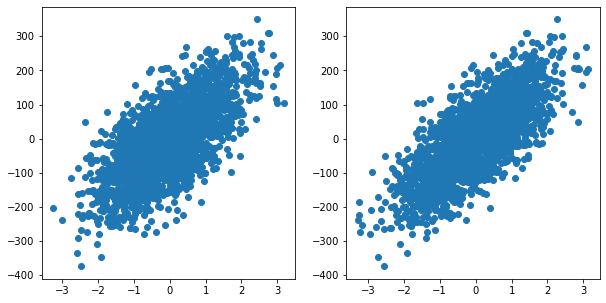

In [12]:
from sklearn.datasets import make_regression

df = make_regression(
    n_samples=2000, 
    n_features=2,

)
# df[0][:,1]
fig, ax = plt.subplots(1, df[0].shape[1], figsize=(5*df[0].shape[1],5))
# 
if isinstance(ax,np.ndarray):
    for i in range(df[0].shape[1]):
        ax[i].scatter(df[0][:,i],df[1])
else:
    ax.scatter(df[0],df[1])

[ 0.         63.52022907 81.36337142]


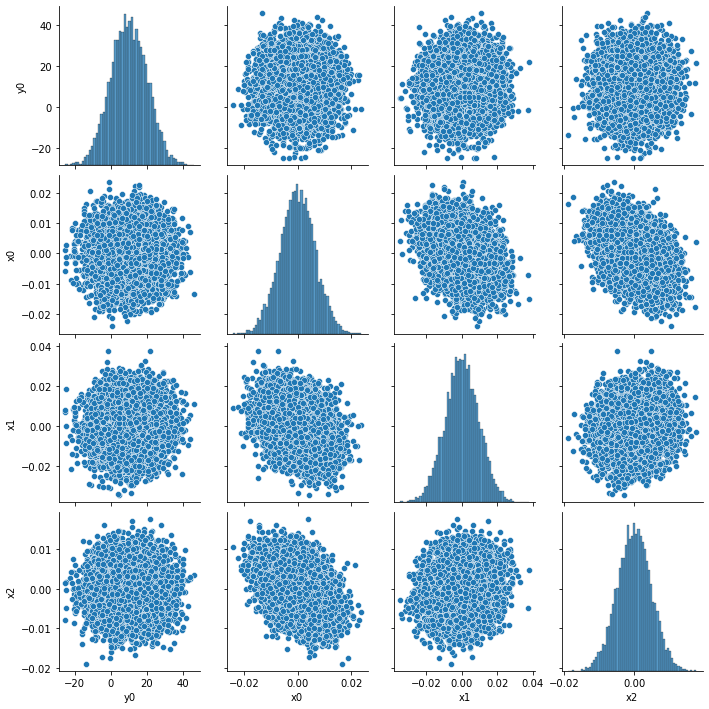

In [13]:
from sklearn.datasets import make_regression

df = make_regression(
    n_samples=10**4, 
    n_features=3,
    n_informative=2,
    bias=10,
    noise=10,
    coef=True,
    effective_rank=1
)

print(df[2])

df_to_plot = pd.concat(
    [
        pd.DataFrame(df[1]).add_prefix('y'),
        pd.DataFrame(df[0]).add_prefix('x')
    ],
    axis=1
)

sns.pairplot(df_to_plot)



## Temperature series forecasting

1. Load the Second World War Weather dataset.

In [14]:
import pandas as pd
from pathlib import Path

Path.cwd()

WindowsPath('d:/Documenti/Git_repositories/Data_science_lab/data-science-lab-1/MyRepo/Lab8')

In [15]:
df_IN = pd.read_csv('Summary of Weather.csv')

df_IN.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119040 entries, 0 to 119039
Data columns (total 31 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   STA          119040 non-null  int64  
 1   Date         119040 non-null  object 
 2   Precip       119040 non-null  object 
 3   WindGustSpd  532 non-null     float64
 4   MaxTemp      119040 non-null  float64
 5   MinTemp      119040 non-null  float64
 6   MeanTemp     119040 non-null  float64
 7   Snowfall     117877 non-null  object 
 8   PoorWeather  34237 non-null   object 
 9   YR           119040 non-null  int64  
 10  MO           119040 non-null  int64  
 11  DA           119040 non-null  int64  
 12  PRCP         117108 non-null  object 
 13  DR           533 non-null     float64
 14  SPD          532 non-null     float64
 15  MAX          118566 non-null  float64
 16  MIN          118572 non-null  float64
 17  MEA          118542 non-null  float64
 18  SNF          117877 non-

D:\Anaconda\envs\data_science_lab_2\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (7,8,18,25) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [16]:
df_sensors_IN = pd.read_csv('Weather Station Locations.csv')

df_sensors_IN.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 0 to 160
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   WBAN              161 non-null    int64  
 1   NAME              161 non-null    object 
 2   STATE/COUNTRY ID  161 non-null    object 
 3   LAT               161 non-null    object 
 4   LON               161 non-null    object 
 5   ELEV              161 non-null    int64  
 6   Latitude          161 non-null    float64
 7   Longitude         161 non-null    float64
dtypes: float64(2), int64(2), object(4)
memory usage: 10.2+ KB


2. ...checking for the top 10 most complete sensors (in terms of collected data) the distribution of the recorded mean temperatures (MeanTemp column).

22508    2192
10701    2185
22502    2154
22504    2118
10803    1750
Name: STA, dtype: int64


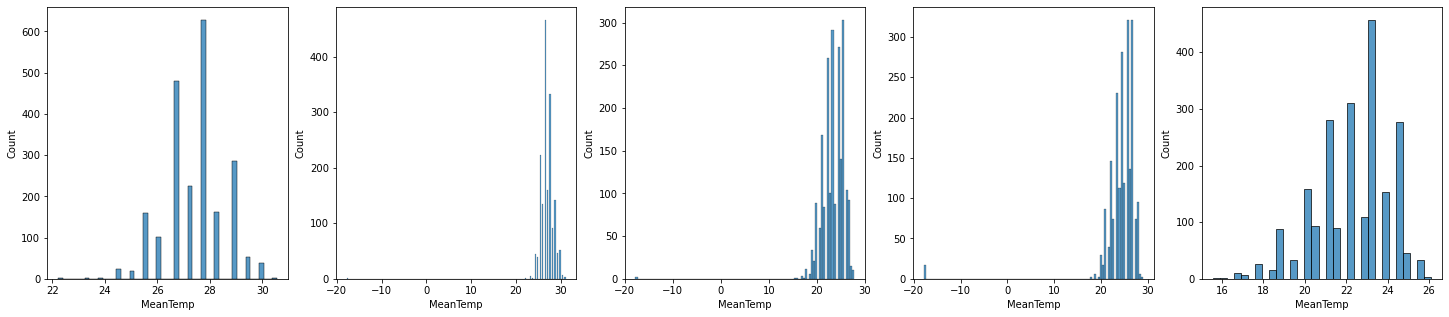

In [29]:
n_top = 5

top10_STA = df_IN['STA'].value_counts().head(n_top)

print(top10_STA)

df = df_IN.loc[df_IN['STA'].isin(list(top10_STA.index)),['STA','Date','MaxTemp','MinTemp','MeanTemp']]

df['Date'] = pd.to_datetime(df['Date'])

fig, ax = plt.subplots(1,n_top,figsize=(5*n_top,5))
for i,sta in enumerate(df['STA'].unique()):
    df_considered = df.loc[df['STA']==sta,:]
    sns.histplot(df_considered,x='MeanTemp',ax=ax[i])

3. Filter the data by STA (Station) and extract the mean temperature measurements corresponding to sensor with id 22508.
Plot the temperatures time series exploiting matplotlib and show on the x axis the corresponding datetimes

Date
1940-01-01    20.000000
1940-01-02    19.444444
1940-01-03    20.000000
1940-01-04    21.111111
1940-01-05    18.333333
                ...    
1945-12-27    20.555556
1945-12-28    21.111111
1945-12-29    20.000000
1945-12-30    21.111111
1945-12-31    21.666667
Name: MeanTemp, Length: 2192, dtype: float64


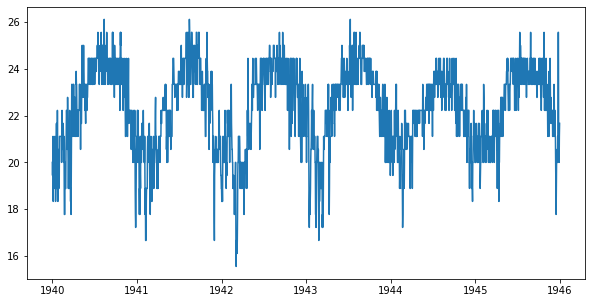

In [48]:
temperatures = df.loc[df['STA']== 22508,['Date','MeanTemp']].set_index('Date')['MeanTemp']
print(temperatures)
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(temperatures.index.values,temperatures.values)

5. To predict the next day temperature, a rolling window pre-processing should be performed to convert the time series into a structured dataset.

In [52]:
W = 3
X = list()
y = list()

for i in range(temperatures.size - W):
    X.append(temperatures.iloc[i:i + W].values.T)
    y.append(temperatures.iloc[i + W])

X = np.array(X)
y = np.array(y)
# X.shape, y.shape

6. Split the dataset into train and test sets and keep in mind that you are evaluating the forecasting of a time series.

In [64]:
X_df = pd.DataFrame(X, index=temperatures.index[:temperatures.size - W]).add_prefix('t')
y_s = pd.Series(y, index=temperatures.index[:temperatures.size - W])
print(X_df.head())
print(y_s.head())

                   t0         t1         t2
Date                                       
1940-01-01  20.000000  19.444444  20.000000
1940-01-02  19.444444  20.000000  21.111111
1940-01-03  20.000000  21.111111  18.333333
1940-01-04  21.111111  18.333333  20.000000
1940-01-05  18.333333  20.000000  20.555556
Date
1940-01-01    21.111111
1940-01-02    18.333333
1940-01-03    20.000000
1940-01-04    20.555556
1940-01-05    18.888889
dtype: float64


In [66]:
X_train, y_train = X_df.loc['1940':'1944'], y_s['1940':'1944']

from datetime import date
initial_day = date(1944, 12, 31) + pd.Timedelta(f"{W} days")
X_test, y_test = X_df.loc[initial_day:], y_s.loc[initial_day:]

7. Now, using the regression techniques that you have learned, try to identify which is the most accurate regression model evaluating the r2_score and the mean_squared_error

In [67]:
t = PrettyTable()
t.field_names = ['model', 'MSE', 'R2']

for model, name in zip(models, model_names):
    model.fit(X_train, y_train)
    y_hat = model.predict(X_test)
    mse = mean_squared_error(y_test, y_hat)
    r2 = r2_score(y_test, y_hat)
    t.add_row([name, mse, r2])

print(t)

+-----------------------------+--------------------+--------------------+
|            model            |        MSE         |         R2         |
+-----------------------------+--------------------+--------------------+
|       LinearRegression      | 0.770883866871111  | 0.6684666582498315 |
|            Ridge            | 0.7708190312576397 | 0.6684945420446835 |
|             SVR             | 0.7606632382515228 | 0.6728622349464781 |
|    RandomForestRegressor    | 0.8356685245066702 | 0.6406047779289549 |
|         MLPRegressor        | 0.7973728394349434 | 0.6570745692841349 |
| PolynomialRegression_simple | 1.1400192242471665 | 0.5097129420957379 |
|   PolynomialRegression_sin  | 1.139624511741678  | 0.5098826957533238 |
+-----------------------------+--------------------+--------------------+
